In [12]:
import models
import utils
import torch
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

torch.manual_seed(42)

dtype = torch.float
device = torch.device("cpu")
# device = torch.device("cuda:0") # Uncomment this to run on GPU

Y = torch.tensor(np.load('../datasets/floored_exp_correl.npy'), dtype=dtype)
A_true = np.load('../datasets/students_correl.npy')
D_true = np.load('../datasets/questions_correl.npy')
# We assume we know the relevant concept of each question beforehand
concepts = np.nonzero(D_true)
num_students, num_concepts = A_true.shape
num_questions = D_true.shape[0]
guess_prob = 1/5

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Infering parameters of sigmoid IRF

We first conduct coarse hyperparameter search and then train for a longer time on the optimal hyperparameters found on the search.

In [13]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob)
max_acc, best_params = utils.hyperparam_search(models.Sigmoid_Model, init_params, {'lr':(-3,-1), 'reg':(-4,1)}, 10, 300, Y)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

torch.Size([100])


/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1000, 100])) that is different to the input size (torch.Size([100])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


ValueError: Target and input must have the same number of elements. target nelement (100000) != input nelement (100)

In [14]:
l, r, m = best_params
sigmoid_irf = models.Sigmoid_Model(num_students, num_questions, num_concepts, concepts, guess_prob)
optim = torch.optim.SGD(sigmoid_irf.parameters(), lr=l, weight_decay=r, momentum=m)
losses, train_acc, precision = utils.train(sigmoid_irf, optim, 1200, Y)
utils.plot_train_metrics(losses, train_acc, precision)

NameError: name 'best_params' is not defined

Here we calculate the RMSE between the inferred A and D matrices and their actual counterparts.

In [15]:
with torch.no_grad():
    print('RMSE(A, A_true) = ', utils.rmse(sigmoid_irf.A, torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(sigmoid_irf.D, torch.tensor(D_true, dtype=dtype)))

NameError: name 'sigmoid_irf' is not defined

For the sake of some exploration we compare the inferred models accuracy with the accuracy of the model using the actual A and D matrices. We also look at the scores distribution generated by the actual A and D matrices. As it turns out this distribution says a lot about the general behavior of the model, and explains why the (actual) floored exponential model attains higher accuracy on its own dataset than the does the (actual) sigmoid model on its dataset.

In [16]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.two_param_sigmoid_irf(_A[:, concepts[1]], _D[concepts], guess_prob)
preds = (scores >= 0.5).float()
print('Actual dist accuracy: ', torch.sum(Y == preds).item() / (Y.shape[0] * Y.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Actual dist accuracy:  0.56243


NameError: name 'train_acc' is not defined

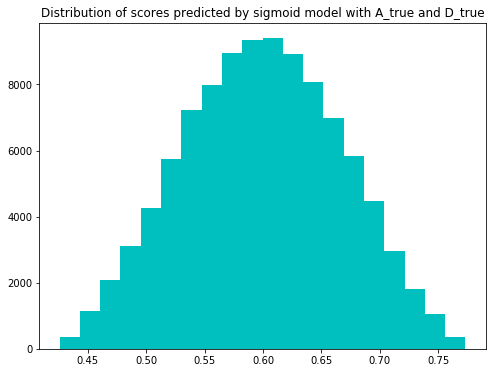

In [17]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by sigmoid model with A_true and D_true')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()

## Infering parameters of Floored exponential IRF

In [19]:
init_params = (num_students, num_questions, num_concepts, concepts, guess_prob, 10)
max_acc, best_params = utils.hyperparam_search(models.FE_Model, init_params, {'lr':(-6,-2), 'reg':(-3,1), 'momentum':(-1, 0)}, 10, 300, Y)

print('Best parameters: lr={}, reg={}, momentum={}'.format(*best_params))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([4, 2, 0, 2, 1, 2, 3, 1, 3, 0, 1, 1, 0, 3, 4, 2, 1, 4, 3, 4, 4, 3,
       2, 0, 2, 0, 1, 1, 3, 2, 0, 4, 3, 1, 1, 1, 3, 1, 2, 2, 1, 3, 1, 1,
       1, 4, 2, 1, 3, 3, 1, 2, 3, 3, 4, 1, 1, 1, 1, 3, 2, 0, 0, 1, 4, 0,
       4, 4, 3, 4, 2, 4, 0, 1, 0, 0, 1, 2, 4, 3, 2, 2, 4, 3, 3, 1, 0, 1,
       3, 0, 1, 2, 0, 0, 0, 0, 0, 3, 0, 1]))
tensor([ 0.0336, -0.1050, -0.0534,  0.1480, -0.0084, -0.0145,  0.0050,  0.0233,
         0.0591, -0.0182,  0.0290, -0.1230, -0.0671, -0.0376,  0.0756, -0.1156,
         0.0010, -0.0099,  0.1132,  0.0612, -0.0863,  0.02

/usr/local/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([1000, 100])) that is different to the input size (torch.Size([100])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


ValueError: Target and input must have the same number of elements. target nelement (100000) != input nelement (100)

In [11]:
l, r, m = best_params
fe_irf = models.FE_Model(num_students, num_questions, num_concepts, concepts, guess_prob, 10)
optim = torch.optim.SGD(fe_irf.parameters(), lr=l, weight_decay=r, momentum=m)
losses, train_acc, precision = utils.train(fe_irf, optim, 2000, Y)
utils.plot_train_metrics(losses, train_acc, precision)

NameError: name 'best_params' is not defined

In [54]:
with torch.no_grad():
    print('RMSE(A, A_true) = ', utils.rmse(fe_irf.A, torch.tensor(A_true, dtype=dtype)))
    print('RMSE(D, D_true) = ', utils.rmse(fe_irf.D, torch.tensor(D_true, dtype=dtype)))

RMSE(A, A_true) =  0.5557727813720703
RMSE(D, D_true) =  0.26908889412879944


In [55]:
_A = torch.tensor(A_true, dtype=dtype)
_D = torch.tensor(D_true, dtype=dtype)
scores = models.floored_exp_irf(_A[:, concepts[1]], _D[concepts], 10, guess_prob)
preds = (scores >= 0.5).float()
print('Actual dist accuracy: ', torch.sum(Y == preds).item() / (Y.shape[0] * Y.shape[1]))
#print(f.binary_cross_entropy(scores, Y))
print('Inferred model accuracy: ', train_acc[-1])
print('Inferred model precision: ', precision[-1])

Actual dist accuracy:  0.80246
Inferred model accuracy:  0.7035800218582153
Inferred model precision:  0.7598390579223633


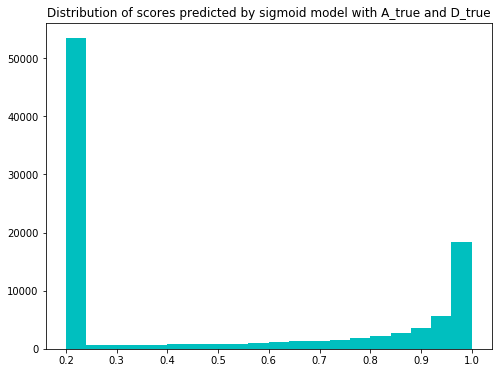

In [56]:
plt.figure(figsize=(8,6))
plt.title('Distribution of scores predicted by sigmoid model with A_true and D_true')
plt.hist(scores.numpy().flatten(), color='c', bins=20)
plt.show()